In [1]:
import duckdb
import pandas as pd

con = duckdb.connect()
con.execute("SET temp_directory='data/processed/tmp';")
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA memory_limit='1GB';")

con.execute("""
CREATE OR REPLACE VIEW events AS
SELECT * FROM read_parquet([
  'data/processed/events_2019_oct.parquet',
  'data/processed/events_2019_nov.parquet'
]);
""")

con.execute("""
CREATE OR REPLACE VIEW events_enriched AS
SELECT
  *,
  DATE(event_time) AS event_date,
  STRFTIME(event_time, '%Y-%m') AS event_month,
  STRFTIME(event_time, '%Y-%W') AS event_week
FROM events;
""")


In [2]:
first_purchase = con.execute("""
SELECT
  user_id,
  MIN(event_week) AS first_purchase_week
FROM events_enriched
WHERE event_type = 'purchase'
GROUP BY user_id
""").df()

first_purchase.head()


,user_id,first_purchase_week
0,529300379,2019-39
1,550914163,2019-39
2,550293057,2019-39
3,532037554,2019-39
4,518029824,2019-39


In [3]:
user_activity = con.execute("""
SELECT
  e.user_id,
  e.event_week,
  f.first_purchase_week
FROM events_enriched e
JOIN (
    SELECT user_id, MIN(event_week) AS first_purchase_week
    FROM events_enriched
    WHERE event_type = 'purchase'
    GROUP BY user_id
) f
ON e.user_id = f.user_id
WHERE e.event_type = 'purchase'
""").df()

user_activity.head()


,user_id,event_week,first_purchase_week
0,554809849,2019-39,2019-39
1,513756880,2019-39,2019-39
2,531974857,2019-39,2019-39
3,516025438,2019-39,2019-39
4,513841396,2019-39,2019-39


In [4]:
retention = con.execute("""
SELECT
  first_purchase_week,
  event_week,
  COUNT(DISTINCT user_id) AS users
FROM (
  SELECT
    e.user_id,
    f.first_purchase_week,
    e.event_week
  FROM events_enriched e
  JOIN (
      SELECT user_id, MIN(event_week) AS first_purchase_week
      FROM events_enriched
      WHERE event_type = 'purchase'
      GROUP BY user_id
  ) f
  ON e.user_id = f.user_id
  WHERE e.event_type = 'purchase'
)
GROUP BY first_purchase_week, event_week
ORDER BY first_purchase_week, event_week;
""").df()

retention.head(20)


,first_purchase_week,event_week,users
0,2019-39,2019-39,78674
1,2019-39,2019-40,15996
2,2019-39,2019-41,13754
3,2019-39,2019-42,10669
4,2019-39,2019-43,8876
5,2019-39,2019-44,8916
6,2019-39,2019-45,10893
7,2019-39,2019-46,6696
8,2019-39,2019-47,6010
9,2019-40,2019-40,85245


In [5]:
retention_with_offset = con.execute("""
SELECT
  first_purchase_week,
  event_week,
  users,
  CAST(SUBSTR(event_week, 6, 2) AS INT) - CAST(SUBSTR(first_purchase_week, 6, 2) AS INT) AS week_number
FROM retention
""").df()

retention_with_offset.head()


,first_purchase_week,event_week,users,week_number
0,2019-39,2019-39,78674,0
1,2019-39,2019-40,15996,1
2,2019-39,2019-41,13754,2
3,2019-39,2019-42,10669,3
4,2019-39,2019-43,8876,4


In [6]:
retention_rates = con.execute("""
WITH base AS (
  SELECT
    first_purchase_week,
    event_week,
    users,
    CAST(SUBSTR(event_week, 6, 2) AS INT) - CAST(SUBSTR(first_purchase_week, 6, 2) AS INT) AS week_number
  FROM retention
),
cohort_sizes AS (
  SELECT
    first_purchase_week,
    users AS cohort_size
  FROM base
  WHERE week_number = 0
)
SELECT
  b.first_purchase_week,
  b.week_number,
  b.users,
  c.cohort_size,
  ROUND(b.users * 1.0 / c.cohort_size, 4) AS retention_rate
FROM base b
JOIN cohort_sizes c
ON b.first_purchase_week = c.first_purchase_week
ORDER BY b.first_purchase_week, b.week_number
""").df()

retention_rates.head(20)


,first_purchase_week,week_number,users,cohort_size,retention_rate
0,2019-39,0,78674,78674,1.0000
1,2019-39,1,15996,78674,0.2033
2,2019-39,2,13754,78674,0.1748
3,2019-39,3,10669,78674,0.1356
4,2019-39,4,8876,78674,0.1128
5,2019-39,5,8916,78674,0.1133
6,2019-39,6,10893,78674,0.1385
7,2019-39,7,6696,78674,0.0851
8,2019-39,8,6010,78674,0.0764
9,2019-40,0,85245,85245,1.0000


In [7]:
retention_matrix = retention_rates.pivot(
    index='first_purchase_week',
    columns='week_number',
    values='retention_rate'
)

retention_matrix.head()


week_number,0,1,2,3,4,5,6,7,8
first_purchase_week,,,,,,,,,
2019-39,1.0,0.2033,0.1748,0.1356,0.1128,0.1133,0.1385,0.0851,0.0764
2019-40,1.0,0.1609,0.1109,0.0891,0.0890,0.1212,0.0674,0.0633,NaN
2019-41,1.0,0.1345,0.0914,0.0901,0.1150,0.0670,0.0577,NaN,NaN
2019-42,1.0,0.1098,0.0890,0.1125,0.0628,0.0555,NaN,NaN,NaN
2019-43,1.0,0.1225,0.1192,0.0664,0.0574,NaN,NaN,NaN,NaN


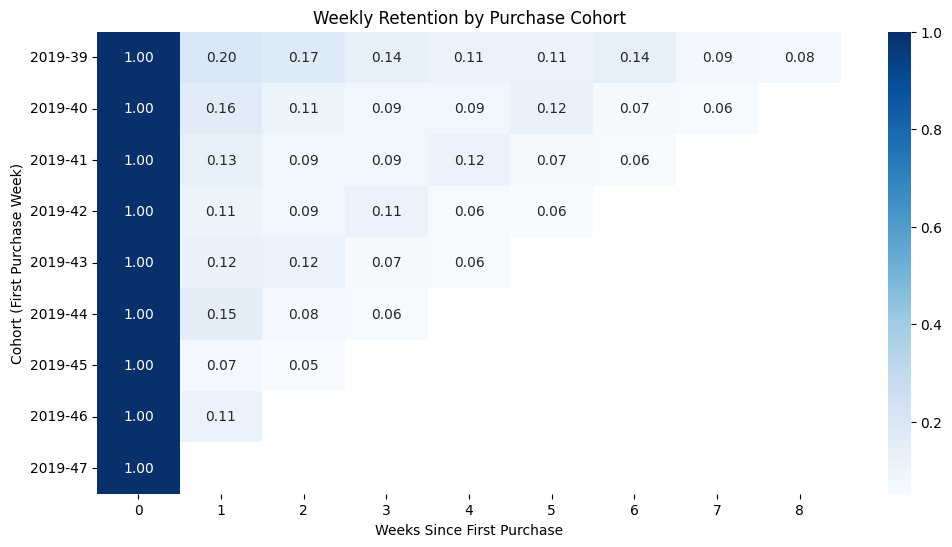

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(retention_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title("Weekly Retention by Purchase Cohort")
plt.ylabel("Cohort (First Purchase Week)")
plt.xlabel("Weeks Since First Purchase")
plt.show()
